## Imports

In [1]:
from utils.prepare_data import prepare_short_data, prepare_full_data
from environment import Environment
from datetime import timedelta
from models.base_model import Base_model
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Constants

In [2]:
df = prepare_full_data('data/Data_RU.xlsx')
env = Environment(data=df, stock_name='AFKS', initial_money=1000)

In [3]:
start_date = env.first_date()

In [4]:
day_count = env.data.shape[0]

In [5]:
model = Base_model()
# here we have to train the model

In [6]:
env.reset()
for i in range(10, day_count):
    obs = env.observation(i)
    action = model.predict(obs)
    env.transition(action, i)
    if i % 100 == 0:
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200


In [7]:
env.money

[1000,
 array([987.325]),
 array([974.825]),
 array([962.305]),
 array([974.925]),
 array([974.925]),
 array([974.925]),
 array([974.925]),
 array([974.925]),
 array([962.775]),
 array([962.775]),
 array([962.775]),
 array([950.775]),
 array([950.775]),
 array([950.775]),
 array([950.775]),
 array([939.27]),
 array([939.27]),
 array([951.92]),
 array([939.6]),
 array([927.35]),
 array([927.35]),
 array([915.15]),
 array([902.75]),
 array([914.94]),
 array([914.94]),
 array([914.94]),
 array([902.63]),
 array([902.63]),
 array([890.54]),
 array([902.56]),
 array([902.56]),
 array([902.56]),
 array([890.38]),
 array([890.38]),
 array([902.405]),
 array([890.52]),
 array([878.645]),
 array([866.885]),
 array([855.125]),
 array([855.125]),
 array([843.215]),
 array([831.245]),
 array([819.285]),
 array([807.41]),
 array([807.41]),
 array([807.41]),
 array([795.665]),
 array([807.34]),
 array([818.995]),
 array([807.145]),
 array([807.145]),
 array([818.895]),
 array([818.895]),
 array([818

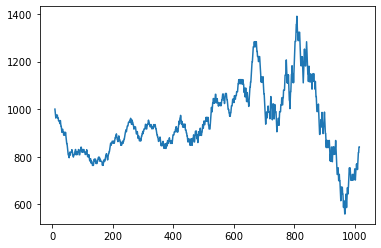

In [9]:
plt.plot(range(9, day_count), env.money)

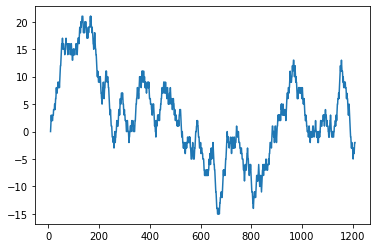

In [10]:
plt.plot(range(9, day_count), env.stocks)